In [1]:
import scanpy as sc
import anndata
import numpy as np

In [6]:
dir_path = "/home/krushna/Documents/Data_integration/SCRNA_Datasets/All_h5ad/"
emb_dir =  "/home/krushna/Documents/Data_integration/Othermethods/ourmethod/self-sup/pipeline_tf2 50/step1/"
batch_key_dic = {'Immune_Human' : 'batch',
                 'Lung' : 'batch',
                 'Pancreas' : 'tech',
                 'Human_Mouse' : 'batch',
                 'Human_Retina': "Batch",
                 
                }
cell_type_key_dic = {'Immune_Human' : 'final_annotation',
                 'Lung' : 'cell_type',
                 'Pancreas' : 'celltype',
                 'Human_Mouse' : "celltype",
                 "Human_Retina":"Subcluster",
                    }    

#got these results from GMM
req_clus_dic = {"Lung" : 17,
                        "Pancreas": 14,
                        "Immune_Human": 16,
                "Human_Retina" : 13
                       }

def load_data(dataset,batch_key):
    adata =sc.read_h5ad(dir_path+dataset+'.h5ad')
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    sc.pp.highly_variable_genes(
            adata,
            flavor="seurat",
            n_top_genes=2000,
            layer="counts",
            batch_key=batch_key,
            subset=True
    )
    adata_sep=[]
    for batch in np.unique(adata.obs[batch_key]):
        sep_batch=adata[adata.obs[batch_key]==batch]
        sc.pp.scale(sep_batch,max_value=10)
        adata_sep.append(sep_batch)
    adata=sc.AnnData.concatenate(*adata_sep)
    return adata

In [3]:
dataset = 'Lung'
cell_type = cell_type_key_dic[dataset]
batch = batch_key_dic[dataset]
req_clusters = req_clus_dic[dataset]

In [4]:
# adata = load_data(dataset,batch)
# sc.tl.pca(adata,n_comps=100)

In [7]:
import pandas as pd
adata = sc.read_h5ad(dir_path+dataset+'.h5ad')
emb=pd.read_csv(emb_dir+dataset+"_latent_matrix_c99_step1.csv",header=None)
adata.obsm['X_emb']=emb.values
no_of_cell_types = len(adata.obs[cell_type].unique())

In [8]:
emb=sc.AnnData(emb)
sc.pp.neighbors(emb,use_rep='X',random_state=0)

<ipython-input-8-46dec765373f>:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  emb=sc.AnnData(emb)
/home/krushna/Softwares/Anaconda3/envs/tf2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/krushna/Softwares/Anaconda3/envs/tf2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/krushna/Softwares/Anaconda3/envs/tf2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  fro

In [9]:
def find_resolution(adata_, n_clusters):
    adata = adata_.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = 0)
        labels = adata.obs['louvain']
        obtained_clusters = len(np.unique(labels))
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        iteration = iteration + 1
    print("find resolution iterations = {}, obtained_clusters = {}".format(iteration,obtained_clusters))
    return current_res


In [10]:
opt_res = find_resolution(emb, req_clusters) #no_of_cell_types
opt_res

find resolution iterations = 13, obtained_clusters = 17


0.8544921875

In [11]:
sc.tl.louvain(emb, resolution = opt_res, key_added='pseudo_cell_types')

In [12]:
from annoy import AnnoyIndex
def nn_annoy(mean, emb, no_of_nn):
    tree = AnnoyIndex(emb.shape[1], metric="angular") #euclidean
    tree.set_seed(0)
    for i in range(emb.shape[0]):
        tree.add_item(i, emb[i, :])
    tree.build(50)#n_trees=50
    ind = tree.get_nns_by_vector(mean, no_of_nn, search_k=-1) #search_k=-1 means extract search neighbors
    # ind = np.array(ind)
    return ind

In [13]:
def update_sudo_lables(adata):
    adata.obs['pseudo_cell_types'] = adata.obs['pseudo_cell_types'].cat.add_categories(['NA'])
    for label in adata.obs['pseudo_cell_types'].unique():
        is_label = adata.obs['pseudo_cell_types'] == label
        na_percent = 0.2
        no_of_nn = sum(is_label)-int(sum(is_label)*na_percent)
        names = adata.obs['pseudo_cell_types'][is_label].index
        data = adata[is_label].X 
        mean = data.mean(axis=0)
        ind = nn_annoy(mean,data,no_of_nn)
        adata.obs['pseudo_cell_types'][names] = 'NA'
        adata.obs['pseudo_cell_types'][names[ind]] = label
        

In [12]:
update_sudo_lables(emb)

In [13]:
adata.obs["celltype_NA"]=emb.obs["pseudo_cell_types"].values.copy()

In [14]:
# to check how clusters are looking
cluster = '10'
adata.obs[cell_type][adata.obs["celltype_NA"]== cluster].value_counts()

beta                  128
delta                   1
acinar                  0
activated_stellate      0
alpha                   0
ductal                  0
endothelial             0
epsilon                 0
gamma                   0
macrophage              0
mast                    0
quiescent_stellate      0
schwann                 0
t_cell                  0
Name: celltype, dtype: int64

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    obsm: 'X_emb'
    layers: 'counts'

In [15]:
adata_ori = sc.read_h5ad(dir_path+dataset+'.h5ad')

In [16]:
adata_ori.obs['celltype_NA'] = adata.obs['celltype_NA'].values.copy()

In [17]:
# check if that
adata_ori.obs.celltype_NA.value_counts()

NA    8187
0     2034
1     1949
2      959
3      950
4      561
5      509
6      361
7      347
8      158
9      134
10     129
11      71
12      33
Name: celltype_NA, dtype: int64

In [18]:
adata_ori.write(dir_path+dataset+'_pseudo_cell_types.h5ad')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/krushna/Softwares/Anaconda3/envs/tf2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/krushna/Softwares/Anaconda3/envs/tf2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/krushna/Softwares/Anaconda3/envs/tf2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


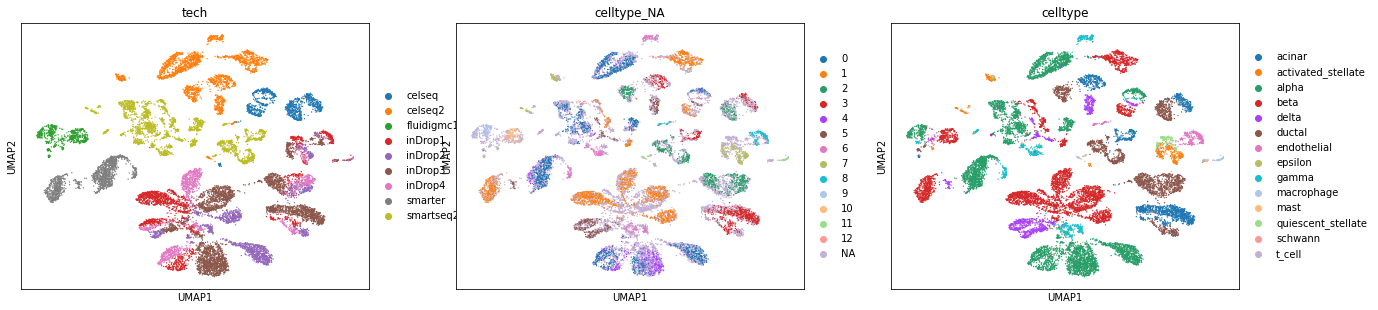

In [19]:
sc.pp.neighbors(adata_ori)
sc.tl.umap(adata_ori)
sc.pl.umap(adata_ori,color=[batch,"celltype_NA",cell_type])

/home/krushna/Softwares/Anaconda3/envs/tf2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


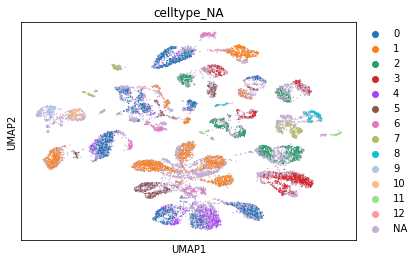

In [20]:
sc.pl.umap(adata_ori,color=["celltype_NA"])